# การทำนายลักษณะกลุ่มโรคของพืช โดยใช้ Plant Disease Model

ตัวอย่างนี้จะเป็นการทำนายลักษณะกลุ่มโรคของพืช (Plant Disease) จากรูปภาพใบไม้ ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายลักษณะกลุ่มโรคของพืชได้สรุปเอาไว้ 4 ขั้นตอน ดังนี้

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** นำเข้าชุดข้อมูลสำหรับการเทรนโมเดล<br>
**ขั้นตอนที่ 2** เตรียมชุดรูปภาพสำหรับเทรนโมเดล<br>
**ขั้นตอนที่ 3** สร้างและเทรนโมเดล<br>
**ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้<br>

In [5]:
#@title **ขั้นตอนที่ 1** เตรียมข้อมูลสำหรับเทรนโมเดล
#@markdown เป็นขั้นตอนการดาวน์โหลดชุดข้อมูลสำหรับนำมาใช้ในการเทรนโมเดล
#@markdown สามารถกดรันเพื่อดาวน์โหลดโฟลเดอร์ **Plant Leaf Disease Dataset**


# ดาวน์โหลดไฟล์โมเดล
%%shell
git clone https://github.com/hengkp/microbit_ml_examples.git

function getfile {
    cp -R "microbit_ml_examples/plant disease prediction/$1" "$1"
}

getfile "Plant Leaf Disease Dataset.zip"
rm -rf microbit_ml_examples

Cloning into 'microbit_ml_examples'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 146 (delta 2), reused 1 (delta 1), pack-reused 143
Receiving objects: 100% (146/146), 54.91 MiB | 41.41 MiB/s, done.
Resolving deltas: 100% (71/71), done.


Number of images: 1200
Number of classes: 4



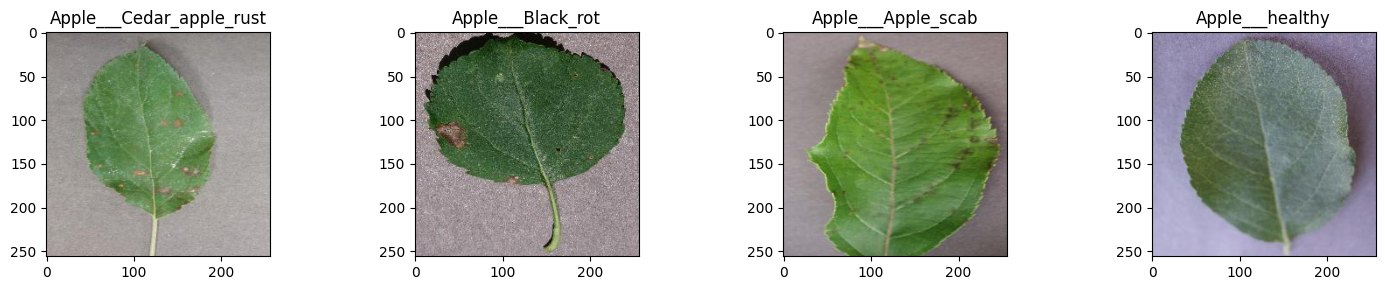

In [32]:
#@title **ขั้นตอนที่ 2** เตรียมชุดรูปภาพสำหรับการเทรนโมเดล
#@markdown เป็นขั้นตอนการเตรียมชุดข้อมูลโดยแยกรูปภาพกับชื่อกลุ่ม สำหรับนำมาใช้ในการเทรนโมเดล ประกอบด้วย<br>1. Apple__Apple_scab<br>2. Apple__healthy<br>3. Apple__Black_rot<br>4. Apple__Cedar_apple_rust<br>

import os
import zipfile
import cv2
from glob import glob
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ฟังก์ชั่นสำหรับแตกไฟล์ ZIP
def extract_zip(filepath):
  with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall()

# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและปรับสัดส่วนค่าสี (intensity) ให้อยู่ในช่วง 0 - 1
def load_images(filename):
    img = io.imread(filename)
    img = cv2.resize(img, (64, 64)) # resize to match inputs of model
    img = img / 255.0 # normalize image data
    img = img.astype(np.float32)
    return img

# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและชื่อ labels จากโฟลเดอร์
def load_images_from_folder(folder):
    images = []
    labels = []
    for foldername in glob(os.path.join(folder,"*")):
        for filename in glob(os.path.join(foldernames[0],"*")):
            if filename.endswith('.JPG'):
                # filepath = os.path.join(folder, foldername, filename)
                img = load_images(filename)
                images.append(img)
                labels.append(foldername.split("/")[-1])  # Use folder name as the label .split('/')[-1]
    return images, labels

# แตกไฟล์ชุดข้อมูล ZIP
filename = 'Plant Leaf Disease Dataset.zip'
extract_zip(filename)

# นำเข้ารูปภาพและชื่อ class ของแต่ละรูป
folder = 'Plant Leaf Disease Dataset'
images, labels = load_images_from_folder(folder)

# แบ่งข้อมูลสำหรับ training และ testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# ปรับตัวแปรให้สอดคล้องกับความต้องการของโมเดล
X_train = np.array(X_train).reshape(len(X_train), -1)
X_test = np.array(X_test).reshape(len(X_test), -1)

# แสดงผลจำนวนรูปภาพที่ใช้และกลุ่ม class ทั้งหมด
print("Number of images:",len(labels))
print("Number of classes:",len(np.unique(labels)))
print('')

# แสดงผลรูปตัวอย่างในแต่ละกลุ่ม
folder_names = [ f for f in os.listdir(folder) if not f.startswith(".") ]
fig, axes = plt.subplots(1, len(folder_names), figsize=(15, 3))
for i, folder_name in enumerate(folder_names):
    file_names = os.listdir(os.path.join(folder, folder_name))
    image_path = os.path.join(folder, folder_name, file_names[0])
    image = io.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(folder_name)
plt.tight_layout()
plt.show()

In [37]:
#@title **ขั้นตอนที่ 3** สร้างและเทรนโมเดล
#@markdown เป็นขั้นตอนการสร้างโมเดลเพื่อจำแนกรายละเอียดของรูปและเทรนโมเดลจากชุดข้อมูลที่เตรียมไว้ โดยมีการแสดงผล Accuracy จากรูปชุดทดสอบ

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# โครงสร้างของโมเดลที่ใช้ทำนาย
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=512)),
    ('svm', SVC())
])

# เทรนโมเดล
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print('Done training.')
print(f"Execution training time: {execution_time:0.2} seconds")
print('')

# วิเคราะห์ค่าความแม่นยำ (accuracy)
accuracy = model.score(X_test, y_test)
print('Accuracy:', np.round(accuracy,2))

Done training.
Execution training time: 3.2 seconds

Accuracy: 0.31


Labels class: Apple___healthy
Predicted disease: Apple___healthy


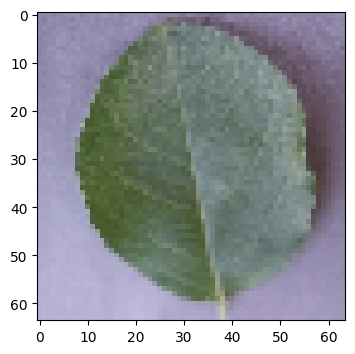

In [34]:
#@title **ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้
#@markdown ในขั้นตอนนี้จะเป็นการนำเข้ารูปภาพที่ต้องการทำนายมาทดสอบผ่านโมเดลที่เตรียมไว้

from matplotlib import pyplot as plt

# นำเข้ารูปภาพที่ต้องการทดสอบ
filename = 'Plant Leaf Disease Dataset/Apple___healthy/image (1).JPG'
img = load_images(filename)
img_input = np.array(img).reshape(1, -1)

# ทำนายกลุ่มของรูปภาพที่ต้องการทดสอบ
prediction = model.predict(img_input)
print('Labels class:',filename.split('/')[-2])
print('Predicted disease:', prediction[0])

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(4, 4)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

\* ไฟล์เนื้อหาทั้งหมดรวมถึงโมเดลและชุดข้อมูลสำหรับการทำนายลักษณะกลุ่มโรคของพืชนี้ สามารถเข้าไปศึกษาเพิ่มเติมและดาวน์โหลดได้ที่[ https://github.com/hengkp/microbit_ml_examples](https://github.com/hengkp/microbit_ml_examples/tree/main/microgreens%20growth%20prediction)